In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import whisper
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from transformers import pipeline
from sklearn.cluster import KMeans

In [5]:
model = whisper.load_model("base")
sentiment_pipeline = pipeline("sentiment-analysis")

100%|███████████████████████████████████████| 139M/139M [00:49<00:00, 2.95MiB/s]
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [13]:
def load_audio_files(base_path):
    audio_data = []
    labels = []
    pd_path = os.path.join(base_path, "PD_AH", "PD_AH")
    ac_path = os.path.join(base_path, "HC_AH")
    for path, label in [(pd_path, "parkinson"), (ac_path, "common")]:
        for file in os.listdir(path):
            if file.endswith(".wav"):
                filepath = os.path.join(path, file)
                y, sr = librosa.load(filepath, sr=None)
                audio_data.append((file, y, sr))
                labels.append(label)
    return audio_data, labels

In [7]:
def extract_audio_features(audio_data):
    features = []
    for filename, y, sr in audio_data:
        duration = librosa.get_duration(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_mean = np.mean(pitches[pitches > 0])
        zcr = np.mean(librosa.feature.zero_crossing_rate(y)[0])
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        mfcc_mean = np.mean(mfccs)
        features.append([filename, duration, tempo, pitch_mean, zcr, mfcc_mean])
    return pd.DataFrame(features, columns=["filename", "duration", "tempo", "pitch_mean", "zcr", "mfcc_mean"])
    

In [22]:
import soundfile as sf

def transcribe(audio_data):
    transcripts = []

    for filename, y, sr in audio_data:
        if sr != 16000:
            y = librosa.resample(y, orig_sr=sr, target_sr=16000)
            sr = 16000
        
        if y.ndim > 1:
            y = np.mean(y, axis=1)

        result = model.transcribe(y, language="en", fp16=False)
        transcripts.append((filename, result["text"]))

    return transcripts

In [18]:
def extract_nlp_features(transcripts):
    features = []
    for filename, text in transcripts:
        words = text.split()
        wpm = len(words) / 0.5
        hesitations = len(re.findall(r"\b(uh|um|er|ah)\b", text.lower()))
        avg_word_len = np.mean([len(w) for w in words]) if words else 0
        sentiment = sentiment_pipeline(text)[0]["score"]
        features.append([filename, wpm, hesitations, avg_word_len, sentiment])
    return pd.DataFrame(features, columns=["filename", "wpm", "hesitations", "avg_word_len", "sentiment_score"])

In [19]:
def merge_features(audio_df, nlp_df, labels):
    df = pd.merge(audio_df, nlp_df, on="filename")
    df["label"] = labels
    return df

In [20]:
def detect_anomalies(df):
    X = df.drop(columns=["filename", "label"])
    X_scaled = StandardScaler().fit_transform(X)
    iso = IsolationForest(contamination=0.2)
    df["anomaly"] = iso.fit_predict(X_scaled)
    return df, X_scaled

def visualize_clusters(X_scaled, labels):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    kmeans = KMeans(n_clusters=2)
    clusters = kmeans.fit_predict(X_pca)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, style=clusters)
    plt.title("Cognitive Pattern Clusters (PCA)")
    plt.show()

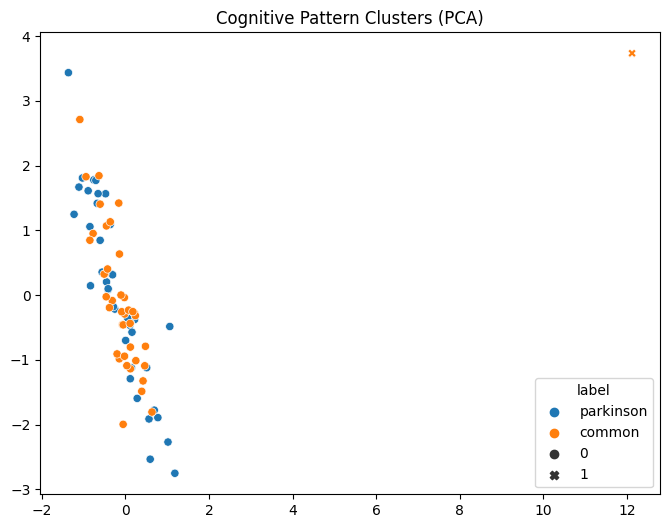

                                             filename  duration  \
0   AH_545616858-3A749CBC-3FEB-4D35-820E-E45C3E5B9...  5.487875   
1   AH_545622717-461DFFFE-54AF-42AF-BA78-528BD505D...  3.028250   
2   AH_545622718-C052AD58-5E6B-4ADC-855C-F76B66BAF...  1.710125   
3   AH_545622719-52C23861-6E0D-41E0-A3D8-9358C28C0...  5.484125   
4   AH_545622720-E1486AF6-8C95-47EB-829B-4D62698C9...  3.682375   
..                                                ...       ...   
76   AH_803T_66094C40-AE64-4AD3-AA97-B052C69DA3EF.wav  2.731000   
77   AH_821C_8F9D5EF0-18B2-4967-B36D-82E014792BC3.wav  4.650500   
78   AH_888A_7F1444B0-B12C-4B55-AF2A-463395DCAF3C.wav  2.839625   
79   AH_904H_85B22FC1-BA09-4A17-A374-B00B2445CD27.wav  3.024375   
80   AH_942A_3F7867F3-1AE2-4BE6-B5EC-AC3157D310CF.wav  1.942250   

                   tempo   pitch_mean       zcr  mfcc_mean   wpm  hesitations  \
0   [133.92857142857142]   709.371277  0.158249  -5.705164   2.0            1   
1   [104.16666666666667]   722.68

In [23]:
audio_data, labels = load_audio_files("23849127")
audio_df = extract_audio_features(audio_data)
transcripts = transcribe(audio_data)
nlp_df = extract_nlp_features(transcripts)
merged_df = merge_features(audio_df, nlp_df, labels)
scored_df, X_scaled = detect_anomalies(merged_df)
visualize_clusters(X_scaled, scored_df["label"])
print(scored_df)